# Comparison of Isomap versions on faces data
### (neighbors from sklearn vs neighbors from pynndescent)

In [1]:
import sys
from pprint import pprint
sys.path.append('../')

In [2]:
from typing import Union, Callable, Optional
import warnings
import torch
import torch.nn.functional as F
import pynndescent
from scipy.spatial import distance

from paradime import relationdata
from paradime import relations
from paradime import transforms
from paradime import dr
from paradime.types import BinaryTensorFun, TensorLike
Transform = Union[transforms.RelationTransform, list[transforms.RelationTransform]]
from paradime import utils
import paradime
from matplotlib import pyplot as plt
import numpy as np
import sklearn.datasets

In [17]:
import sklearn.datasets as dt
faces = dt.fetch_olivetti_faces()
X_faces = faces.data
y_faces = faces.target
ind = y_faces < 6
X_faces = X_faces[ind,:]
y_faces = y_faces[ind]

In [18]:
data = X_faces
data.shape


(60, 4096)

In [12]:
# isomap with neighbours of sklearn
paradime.utils.seed.seed_all(42);
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap = paradime.dr.ParametricDR(
    model=torch.nn.Linear(4096, 2, bias=False),
    global_relations=paradime.relations.GeodesicDist(
        
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap.train(data)

2023-02-04 22:06:02,372: Initializing training dataset.
2023-02-04 22:06:02,373: Computing global relations 'rel'.
2023-02-04 22:06:02,374: Calculating geodesic distances.
2023-02-04 22:06:02,385: Beginning training phase 'None'.
2023-02-04 22:06:02,389: Loss after epoch 0: 2704745.0
2023-02-04 22:06:02,537: Loss after epoch 50: 116683.484375
2023-02-04 22:06:02,752: Loss after epoch 100: 88384.8671875
2023-02-04 22:06:02,865: Loss after epoch 150: 81334.40625
2023-02-04 22:06:02,983: Loss after epoch 200: 78572.2890625
2023-02-04 22:06:03,096: Loss after epoch 250: 77243.609375
2023-02-04 22:06:03,208: Loss after epoch 300: 76562.609375
2023-02-04 22:06:03,329: Loss after epoch 350: 76200.9765625
2023-02-04 22:06:03,453: Loss after epoch 400: 75995.140625
2023-02-04 22:06:03,606: Loss after epoch 450: 75866.5234375


In [6]:
# new isomap with neighbours from pynndescent
paradime.utils.seed.seed_all(42);
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap_new = paradime.dr.ParametricDR(
    model=torch.nn.Linear(4096, 2, bias=False), 
    global_relations=paradime.relations.GeodesicDistNew(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap_new.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap_new.train(data)

2023-02-04 22:05:22,824: Initializing training dataset.
2023-02-04 22:05:22,825: Computing global relations 'rel'.
2023-02-04 22:05:22,827: Calculating geodesic distances.
2023-02-04 22:05:49,300: Beginning training phase 'None'.
2023-02-04 22:05:49,304: Loss after epoch 0: 2860773.5
2023-02-04 22:05:49,429: Loss after epoch 50: 103631.3359375
2023-02-04 22:05:49,553: Loss after epoch 100: 71556.3828125
2023-02-04 22:05:49,666: Loss after epoch 150: 64685.73046875
2023-02-04 22:05:49,782: Loss after epoch 200: 62065.66796875
2023-02-04 22:05:49,899: Loss after epoch 250: 60771.11328125
2023-02-04 22:05:50,015: Loss after epoch 300: 60038.40625
2023-02-04 22:05:50,135: Loss after epoch 350: 59600.93359375
2023-02-04 22:05:50,252: Loss after epoch 400: 59368.4453125
2023-02-04 22:05:50,440: Loss after epoch 450: 59241.953125


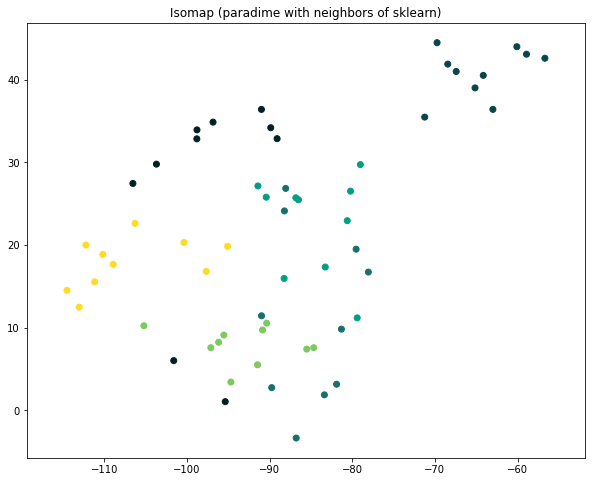

In [13]:
isomap_matrix = pd_isomap.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=y_faces,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime with neighbors of sklearn)");

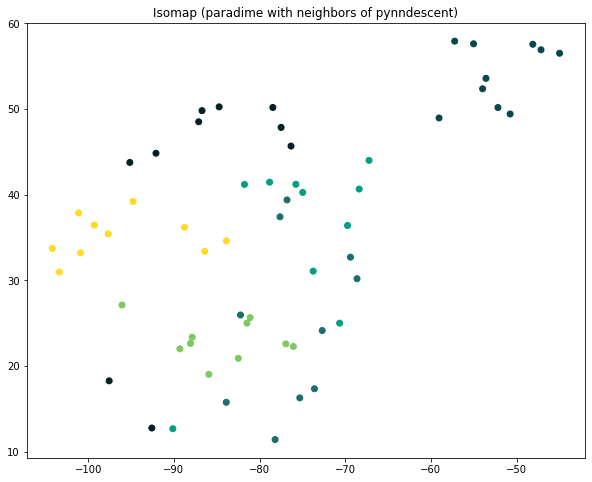

In [14]:
isomap_matrix_new = pd_isomap_new.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(
    *np.stack([np.dot(isomap_matrix_new, i) for i in data]).T,
    c=y_faces,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime with neighbors of pynndescent)");

## Compare with the Isomap of sklearn

In [9]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(data)

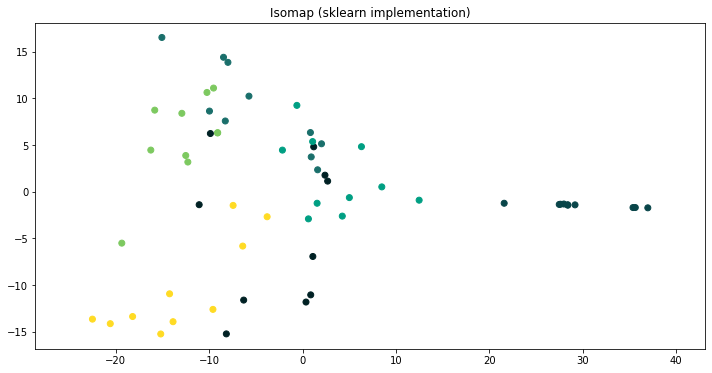

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_faces, cmap=paradime.utils.plotting.get_colormap())
plt.title("Isomap (sklearn implementation)")
plt.axis('equal')
plt.show()

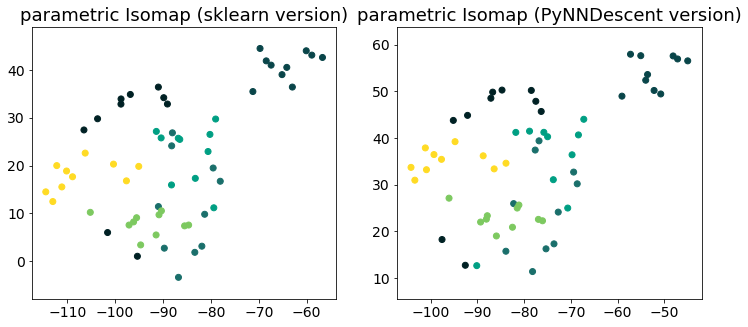

In [28]:
cmap = paradime.utils.plotting.get_colormap()
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=y_faces,
    cmap=cmap,
)

ax2.scatter(
    *np.stack([np.dot(isomap_matrix_new, i) for i in data]).T,
    c=y_faces,
    cmap=cmap,
)

ax1.axis('equal')
ax1.set_title("parametric Isomap (sklearn version)");
ax2.axis('equal')
ax2.set_title("parametric Isomap (PyNNDescent version)");

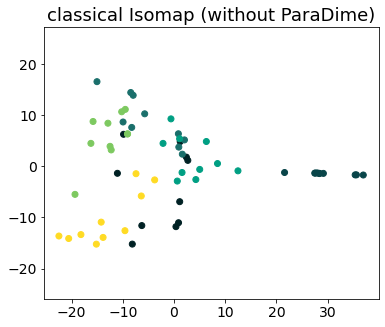

In [29]:
cmap = paradime.utils.plotting.get_colormap()
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

ax1.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_faces, cmap=paradime.utils.plotting.get_colormap())
ax1.set_title("classical Isomap (without ParaDime)")
ax1.axis('equal');
